# Exploración de datos

### En el cuaderno [preprocessing.ipynb](./preprocessing.ipynb) se creo una base de datos SQLite con el siguiente esquema:

![Esquema base de datos](./img/graph.png)

## Lectura de datos

In [20]:
import pandas as pd
import nltk
import gensim
import sqlite3

sqlite_db = "./dataset/fake_news.sqlite"

conn = sqlite3.connect(sqlite_db)
df_news = pd.read_sql_query("SELECT * FROM NEWS", conn)
df_subject = pd.read_sql_query("SELECT * FROM SUBJECT", conn)
df_sent = pd.read_sql_query("SELECT * FROM SENTENCE", conn)
df_entity = pd.read_sql_query("SELECT * FROM ENTITY", conn)
df_type_entity = pd.read_sql_query("SELECT * FROM TYPE_ENTITY", conn)
conn.close()

## Exploración de datos

### Se van a mostrar las tablas "NEWS", "SUBJECT", "SENTENCE", "TYPE_ENTITY" y "ENTITY". Las demás tablas no se muestran dado que la información que tienen es sobre las relaciones de "muchos a muchos" entre tablas de algunas tablas.

### La tabla "NEWS" contiene el texto de las noticias, la fecha y si estas son o no falsas, donde cada columna corresponde a:
- news_id: identificador de la noticia
- title: título de la noticia
- text: cuerpo de la noticia
- subject_id: identificador de la fuente de la noticia
- date: fecha de la noticia
- isfake: valor booleano si es falsa (0) o real (1)
- clean_joined: texto resultado del procesamiento y limpieza

Primeros registros del dataframe correspondiente a la tabla "NEWS"

In [48]:
df_news.head()

,news_id,title,text,subject_id,date,isfake,clean_joined
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,"December 31, 2017",1,budget fight loom republicans flip fiscal scri...
1,2,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0,"December 29, 2017",1,military accept transgender recruit monday pen...
2,3,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,"December 31, 2017",1,senior republican senator mueller washington r...
3,4,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0,"December 30, 2017",1,russia probe help australian diplomat washingt...
4,5,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0,"December 29, 2017",1,trump want postal service charge amazon shipme...


Información general del dataframe correspondiente a la tabla "NEWS"

In [49]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   news_id       15 non-null     int64 
 1   title         15 non-null     object
 2   text          15 non-null     object
 3   subject_id    15 non-null     int64 
 4   date          15 non-null     object
 5   isfake        15 non-null     int64 
 6   clean_joined  15 non-null     object
dtypes: int64(3), object(4)
memory usage: 968.0+ bytes


Registros nulos del dataframe correspondiente a la tabla "NEWS"

In [50]:
df_news.isnull().sum()

news_id         0
title           0
text            0
subject_id      0
date            0
isfake          0
clean_joined    0
dtype: int64

### La tabla "SUBJECT" contiene las fuentes de las noticias, donde cada columna corresponde a:
- subject_id: identificador de la fuente de la noticia
- subject: fuente de la noticia

Primeros registros del dataframe correspondiente a la tabla "SUBJECT"

In [37]:
df_subject.head()

,subject_id,subject
0,0,politicsNews


Información general del dataframe correspondiente a la tabla "SUBJECT"

In [38]:
df_subject.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  1 non-null      int64 
 1   subject     1 non-null      object
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes


Registros nulos del dataframe correspondiente a la tabla "SUBJECT"

In [39]:
df_subject.isnull().sum()

subject_id    0
subject       0
dtype: int64

### La tabla "SENTENCE" contiene las oraciones de cada noticia y si esta oración corresponde a un sentimiento negativo (0), neutro (1) o positivo (2), donde cada columna corresponde a:
- sent_id: identificador de la oración
- sent_text: texto de la oración
- sentiment: sentimiento de la oración - negativo (0), neutro (1) o positivo (2)

Primeros registros del dataframe correspondiente a la tabla "SENTENCE"

In [41]:
df_sent.head()

,sent_id,news_id,sent_text,sentiment
0,0,1,"As U.S. budget fight looms, Republicans flip t...",0
1,1,1,WASHINGTON (Reuters) - The head of a conservat...,1
2,2,1,In keeping with a sharp pivot under way among ...,1
3,3,1,"“Face the Nation,” drew a hard line on federal...",1
4,4,1,When they return from the holidays on Wednesda...,0


Información general del dataframe correspondiente a la tabla "SENTENCE"

In [42]:
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sent_id    284 non-null    int64 
 1   news_id    284 non-null    int64 
 2   sent_text  284 non-null    object
 3   sentiment  284 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 9.0+ KB


Registros nulos del dataframe correspondiente a la tabla "SENTENCE"

In [43]:
df_sent.isnull().sum()

sent_id      0
news_id      0
sent_text    0
sentiment    0
dtype: int64

### La tabla "ENTITY" contiene las entidades extraídas de las noticias, donde cada columna corresponde a:
- ent_id: identificador de la entidad
- ent_text: la identidad
- type_id: llave foránea de la tabla TYPE_ENTITY para obtener el tipo de entidad

Primeros registros del dataframe correspondiente a la tabla "ENTITY"

In [45]:
df_entity.head()

,ent_id,ent_text,type_id
0,0,U.S.,0
1,1,Republicans,1
2,2,WASHINGTON,0
3,3,Reuters,2
4,4,Republican,1


Información general del dataframe correspondiente a la tabla "ENTITY"

In [46]:
df_entity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ent_id    390 non-null    int64 
 1   ent_text  390 non-null    object
 2   type_id   390 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.3+ KB


Registros nulos del dataframe correspondiente a la tabla "ENTITY"

In [47]:
df_entity.isnull().sum()

ent_id      0
ent_text    0
type_id     0
dtype: int64

### La tabla "TYPE_ENTITY" contiene los tipos de las entidades extraídas de las noticias, donde cada columna corresponde a:
- type_id: identificador del tipo de entidad
- type: el tipo de entidad

Registros del dataframe correspondiente a la tabla "TYPE_ENTITY"

In [116]:
df_type_entity

,type_id,type
0,0,GPE
1,1,NORP
2,2,ORG
3,3,DATE
4,4,PERSON
5,5,PERCENT
6,6,MONEY
7,7,CARDINAL
8,8,ORDINAL
9,9,LAW


Información general del dataframe correspondiente a la tabla "TYPE_ENTITY"

In [53]:
df_type_entity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type_id  17 non-null     int64 
 1   type     17 non-null     object
dtypes: int64(1), object(1)
memory usage: 400.0+ bytes


Registros nulos del dataframe correspondiente a la tabla "TYPE_ENTITY"

In [54]:
df_type_entity.isnull().sum()

type_id    0
type       0
dtype: int64

## Combinación de título y texto

In [56]:
df_news['title'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script'

In [57]:
df_news['text'][0]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

In [59]:
df_news['original'] = df_news['title'] + '. ' + df_news['text']
df_news['original'].replace("..", ".")
df_news.head()

,news_id,title,text,subject_id,date,isfake,clean_joined,original
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,"December 31, 2017",1,budget fight loom republicans flip fiscal scri...,"As U.S. budget fight looms, Republicans flip t..."
1,2,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0,"December 29, 2017",1,military accept transgender recruit monday pen...,U.S. military to accept transgender recruits o...
2,3,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,"December 31, 2017",1,senior republican senator mueller washington r...,Senior U.S. Republican senator: 'Let Mr. Muell...
3,4,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0,"December 30, 2017",1,russia probe help australian diplomat washingt...,FBI Russia probe helped by Australian diplomat...
4,5,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0,"December 29, 2017",1,trump want postal service charge amazon shipme...,Trump wants Postal Service to charge 'much mor...


#### Muestra de la combinación anterior

In [60]:
df_news['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script. WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for no

## La noticia más reciente y más vieja:

In [88]:
df_news["parsed_date"] = pd.to_datetime(df_news['date'], infer_datetime_format=True)

### La noticia más vieja

In [89]:
df_news[df_news["parsed_date"] == df_news["parsed_date"].min()]

,news_id,title,text,subject_id,date,isfake,clean_joined,original,parsed_date
14,15,Man says he delivered manure to Mnuchin to pro...,"(In Dec. 25 story, in second paragraph, corre...",0,"December 25, 2017",1,deliver manure mnuchin protest story second pa...,Man says he delivered manure to Mnuchin to pro...,2017-12-25


### La noticia más reciente

In [90]:
df_news[df_news["parsed_date"] == df_news["parsed_date"].max()]

,news_id,title,text,subject_id,date,isfake,clean_joined,original,parsed_date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,"December 31, 2017",1,budget fight loom republicans flip fiscal scri...,"As U.S. budget fight looms, Republicans flip t...",2017-12-31
2,3,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,"December 31, 2017",1,senior republican senator mueller washington r...,Senior U.S. Republican senator: 'Let Mr. Muell...,2017-12-31


## Total de palabras en el Dataset

In [67]:
list_of_words = []
unique_words = set()
for document in df_news.clean_joined:
    for word in gensim.utils.simple_preprocess(document):
        list_of_words.append(word)
        unique_words.add(word)

total_words = len(list_of_words)  # total words
unique_words = len(unique_words)   # total unique words
print("Total words:" + str(total_words) + " unique_words:" + str(unique_words))

Total words:3018 unique_words:1131


In [168]:

tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   count    1 non-null      int64 
 1   subject  1 non-null      object
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes


----

# Visualización de los datos

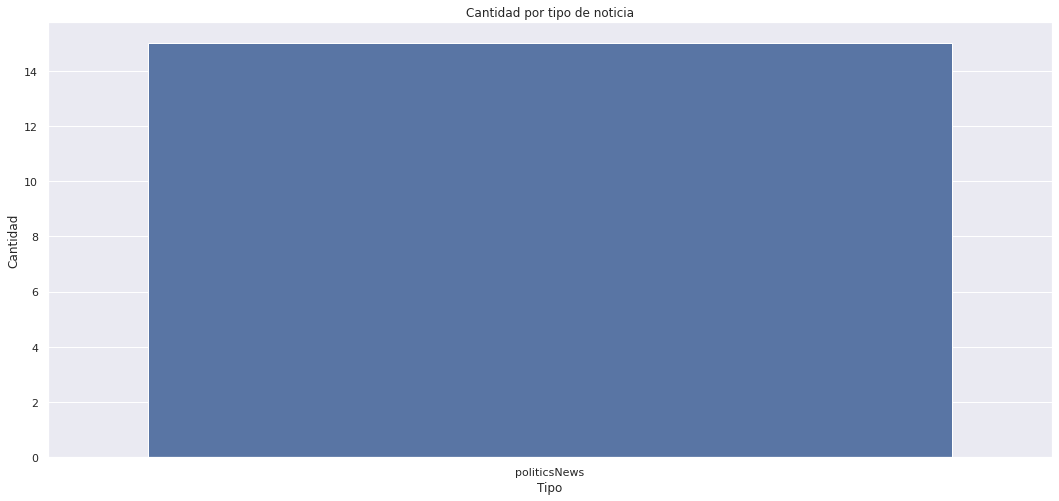

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

conn = sqlite3.connect(sqlite_db)
tmp_df = pd.read_sql_query("SELECT COUNT(*) as count, s.subject FROM NEWS n JOIN SUBJECT s ON n.subject_id = s.subject_id GROUP BY s.subject_id", conn)
conn.close()

plt.figure(figsize = (18, 8))
sns.barplot(x="subject", y="count", data=tmp_df)
plt.title('Cantidad por tipo de noticia')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.show()

In [187]:
tmp_df

,count,subject
0,15,politicsNews


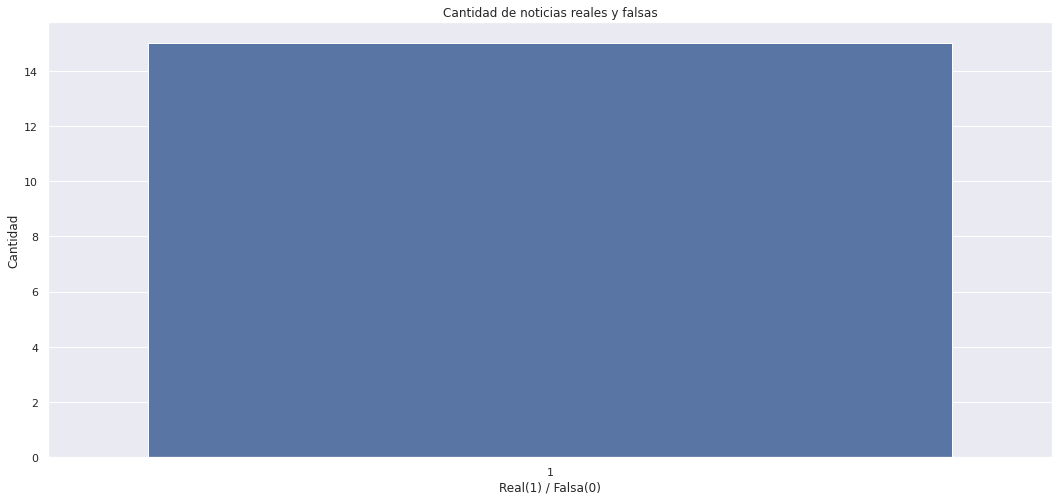

In [188]:
plt.figure(figsize = (18, 8))
sns.countplot(data = df_news, x="isfake")
plt.title('Cantidad de noticias reales y falsas')
plt.xlabel('Real(1) / Falsa(0)')
plt.ylabel('Cantidad')
plt.show()

In [184]:
df_news

,news_id,title,text,subject_id,date,isfake,clean_joined,original,parsed_date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,"December 31, 2017",1,budget fight loom republicans flip fiscal scri...,"As U.S. budget fight looms, Republicans flip t...",2017-12-31
1,2,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0,"December 29, 2017",1,military accept transgender recruit monday pen...,U.S. military to accept transgender recruits o...,2017-12-29
2,3,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,"December 31, 2017",1,senior republican senator mueller washington r...,Senior U.S. Republican senator: 'Let Mr. Muell...,2017-12-31
3,4,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0,"December 30, 2017",1,russia probe help australian diplomat washingt...,FBI Russia probe helped by Australian diplomat...,2017-12-30
4,5,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0,"December 29, 2017",1,trump want postal service charge amazon shipme...,Trump wants Postal Service to charge 'much mor...,2017-12-29
5,6,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",0,"December 29, 2017",1,white house congress prepare talk spending imm...,"White House, Congress prepare for talks on spe...",2017-12-29
6,7,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",0,"December 29, 2017",1,trump russia probe fair timeline unclear west ...,"Trump says Russia probe will be fair, but time...",2017-12-29
7,8,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,0,"December 29, 2017",1,factbox trump twitter approval rating amazon f...,Factbox: Trump on Twitter (Dec 29) - Approval ...,2017-12-29
8,9,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,0,"December 29, 2017",1,trump twitter global warming follow statement ...,Trump on Twitter (Dec 28) - Global Warming. Th...,2017-12-29
9,10,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,0,"December 28, 2017",1,alabama official certify senator elect jones t...,Alabama official to certify Senator-elect Jone...,2017-12-28


In [107]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(list(gensim.parsing.preprocessing.STOPWORDS))
stop_words = list(set(stop_words))

In [108]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_news[df_news.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre las noticias falsas')
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

<Figure size 1440x1440 with 0 Axes>

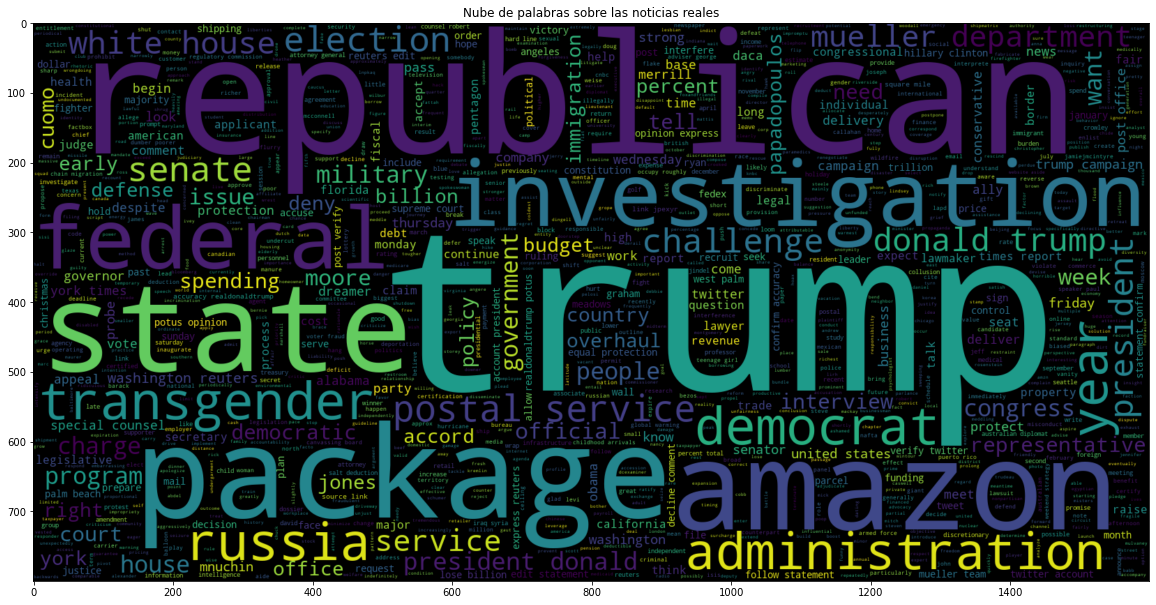

In [109]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_news[df_news.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre las noticias reales')
plt.show()

## Cantidad de oraciones

In [112]:
df_sent.sent_id.count()

284

### Gráfica de cantidad de oraciones por tipo de sentimiento

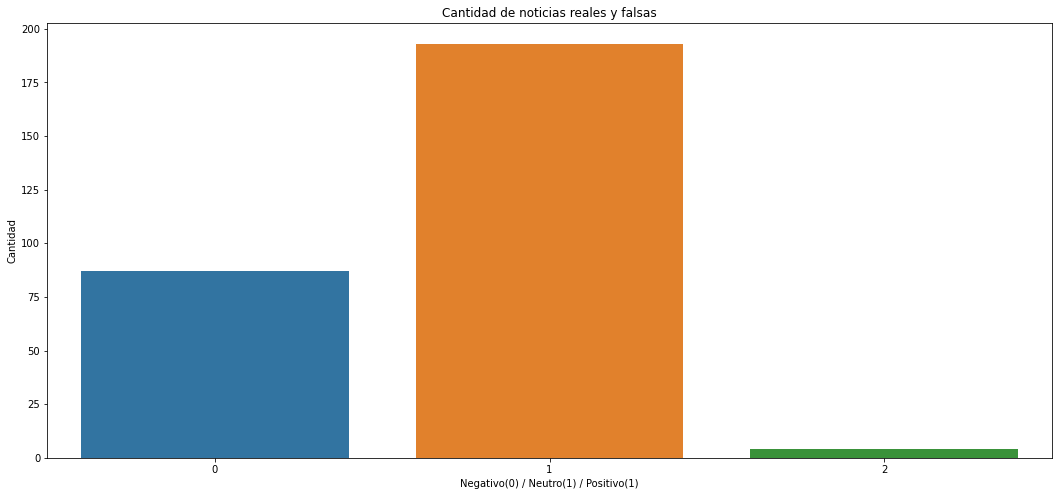

In [114]:
plt.figure(figsize = (18, 8))
sns.countplot(data = df_sent, x="sentiment")
plt.title('Cantidad de noticias reales y falsas')
plt.xlabel('Negativo(0) / Neutro(1) / Positivo(1)')
plt.ylabel('Cantidad')
plt.show()

## Cantidad de Entidades:

In [190]:
df_entity["ent_id"].count()

390

### Gráfica del top 20 de las entidades que más aparecen en las noticias

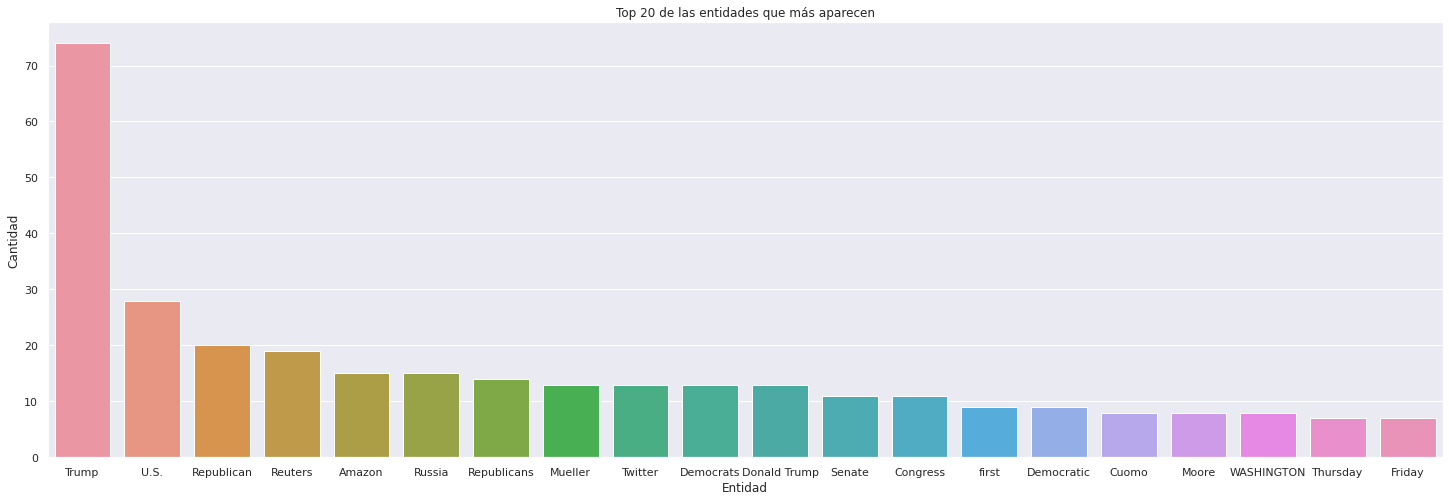

In [405]:
conn = sqlite3.connect(sqlite_db)
tmp_df = pd.read_sql_query("SELECT count(*) as count, ent_text FROM SENTENCE_ENTITY se JOIN ENTITY e ON se.ent_id = e.ent_id  GROUP BY e.ent_id ORDER BY count DESC", conn)
conn.close()

plt.figure(figsize = (25, 8))
sns.barplot(x="ent_text", y="count", data=tmp_df.head(20))
plt.title('Top 20 de las entidades que más aparecen')
plt.xlabel('Entidad')
plt.ylabel('Cantidad')
plt.show()

### Porcentajes del top 15 de las entidades que más aparecen en las noticias

In [406]:
tmp_df = tmp_df.head(15)
tmp_df = tmp_df.set_index("ent_text")

Text(0.5, 0.98, 'test title')

<Figure size 432x288 with 0 Axes>

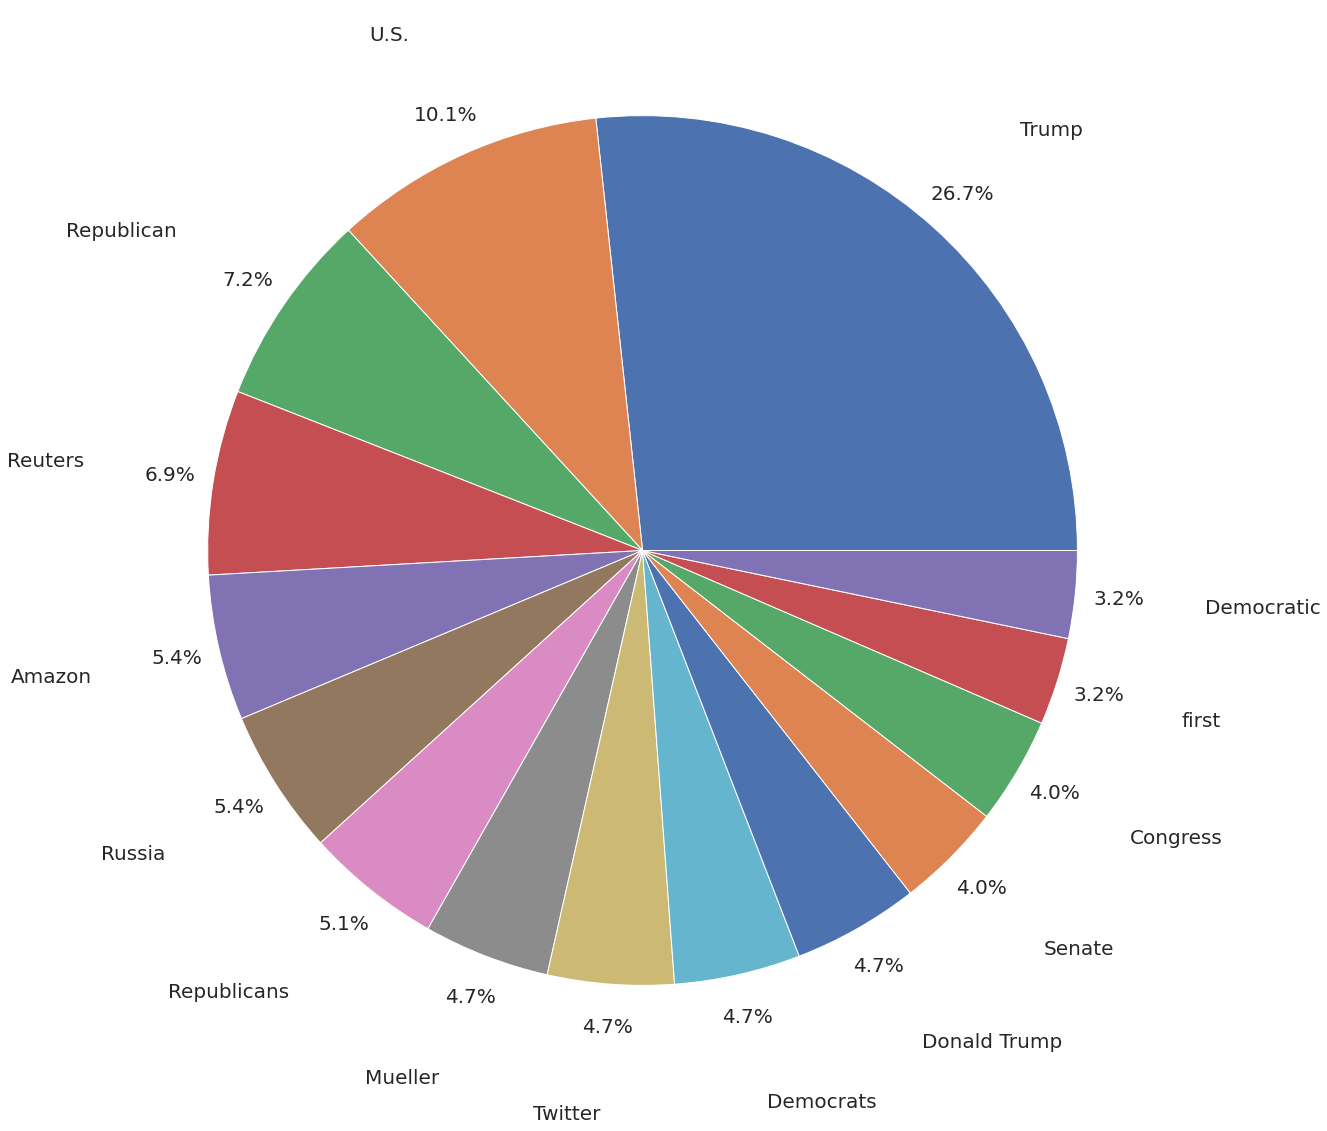

In [407]:
fig = plt.figure()
tmp_df.plot(kind='pie', subplots=True, figsize=(20, 20), autopct='%1.1f%%', fontsize=20, legend=False, ylabel="",pctdistance=1.1, labeldistance=1.3, radius=1)
fig.suptitle('test title', fontsize=230)



### Gráfica de cantidad de entidades por tipo de entidad

In [379]:
df_join_ent_type = df_entity.join(df_type_entity, on='type_id', lsuffix='_entity', rsuffix='_type')
fd_group_ent_type = df_join_ent_type.groupby(by=["type"]).count()
fd_group_ent_type_index = fd_group_ent_type["ent_id"].copy()
fd_group_ent_type.index.name = "type"
fd_group_ent_type.reset_index(inplace=True)
fd_group_ent_type = fd_group_ent_type[["ent_id", "type"]].rename(columns={'ent_id':'count'}).sort_values(by=['count'], ascending=False)

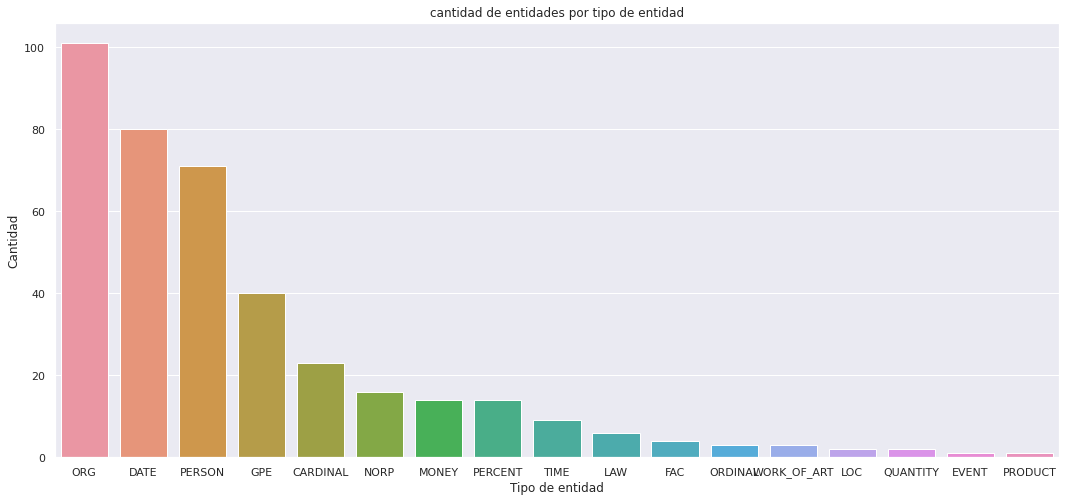

In [404]:
plt.figure(figsize = (18, 8))
sns.barplot(x="type", y="count", data=fd_group_ent_type)
plt.title('cantidad de entidades por tipo de entidad')
plt.xlabel('Tipo de entidad')
plt.ylabel('Cantidad')
plt.show()

### Porcentaje de entidades por tipo de entidad

array([<AxesSubplot:>], dtype=object)

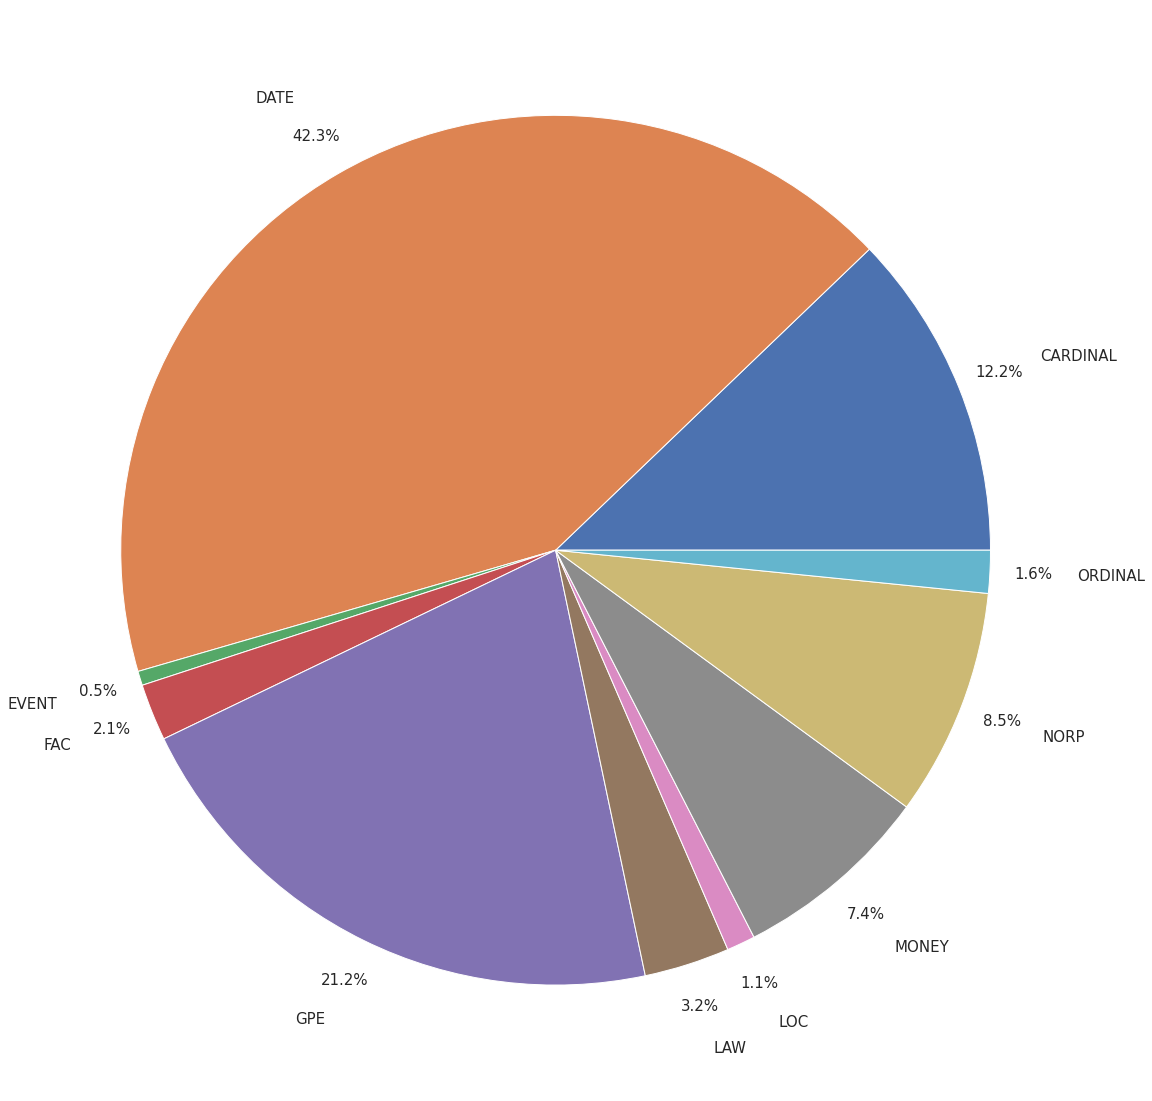

In [403]:
fd_group_ent_type_index.head(10).plot(kind='pie', subplots=True, figsize=(20, 20), autopct='%1.1f%%', fontsize=15, legend=False, ylabel="",pctdistance=1.1, labeldistance=1.2, radius=1)